# Clusterização de Clientes para E-commerce

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



## Etapa 01 - Análise Exploratória dos Dados

In [33]:

# Configurações visuais
sns.set(style="whitegrid")

# Carregamento dos dados
df = pd.read_csv("data.csv", encoding="ISO-8859-1")

# Visualização das 5 primeiras linhas
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [10]:
# Verificando informações gerais
df.info()

# Estatísticas descritivas
df.describe()

# Verificando valores nulos
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Etapa 02 - Pré-processamento dos Dados

In [12]:
# Remover linhas com valores nulos
df.dropna(subset=["CustomerID"], inplace=True)

# Remover transações canceladas (InvoiceNo iniciando com 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Converter InvoiceDate para datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calcular TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Excluir duplicatas
df.drop_duplicates(inplace=True)

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392732 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  object        
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  float64       
 7   Country      392732 non-null  object        
 8   TotalPrice   392732 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.0+ MB


## Etapa 03 - Cálculo das Métricas RFM

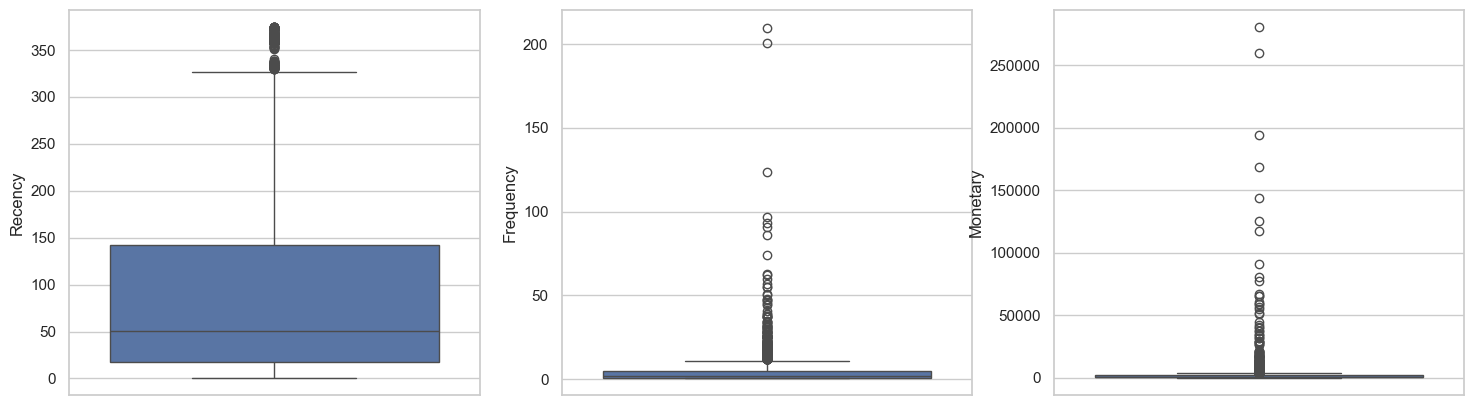

In [13]:
# Data de referência
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Agrupar por cliente e calcular RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Verificar outliers com boxplot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(data=rfm, y='Recency', ax=axes[0])
sns.boxplot(data=rfm, y='Frequency', ax=axes[1])
sns.boxplot(data=rfm, y='Monetary', ax=axes[2])
plt.show()

## Etapa 04 - Clusterização

In [ ]:
# Normalizar os dados
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

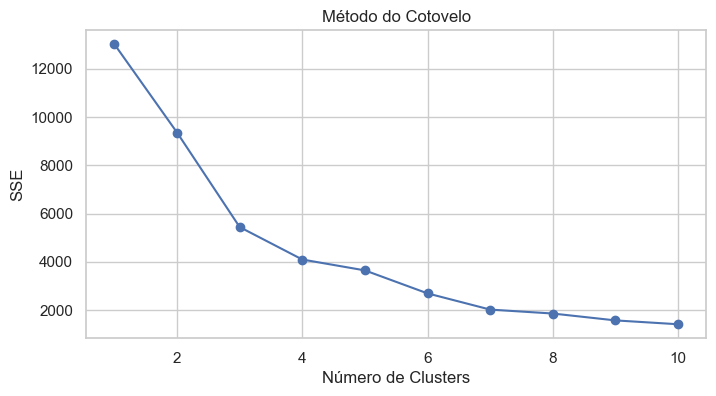

In [25]:
# Método do cotovelo para escolha de K
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.title('Método do Cotovelo')
plt.show()


In [24]:
# Escolhendo K=4 (supondo após visualização do gráfico)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Avaliação do modelo
score = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f"Silhouette Score: {score:.2f}")
rfm.groupby('Cluster').mean()

Silhouette Score: 0.62


,CustomerID,Recency,Frequency,Monetary
Cluster,,,,
0,15201.928910,15.672986,22.047393,12435.086682
1,15344.258004,248.564030,1.551789,476.330547
2,15435.000000,7.384615,82.692308,127187.959231
3,15290.717982,43.910580,3.655748,1344.284013


## Etapa 05 - Visualização e Análise dos Clusters

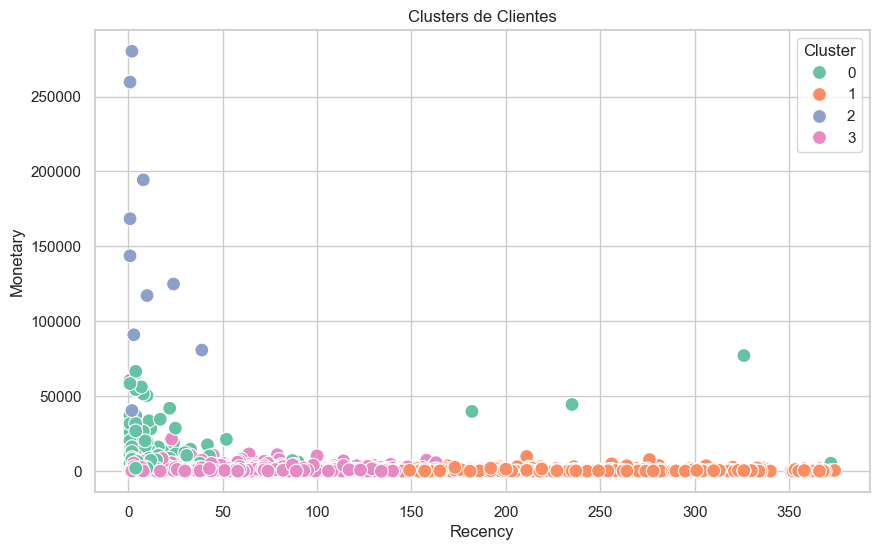

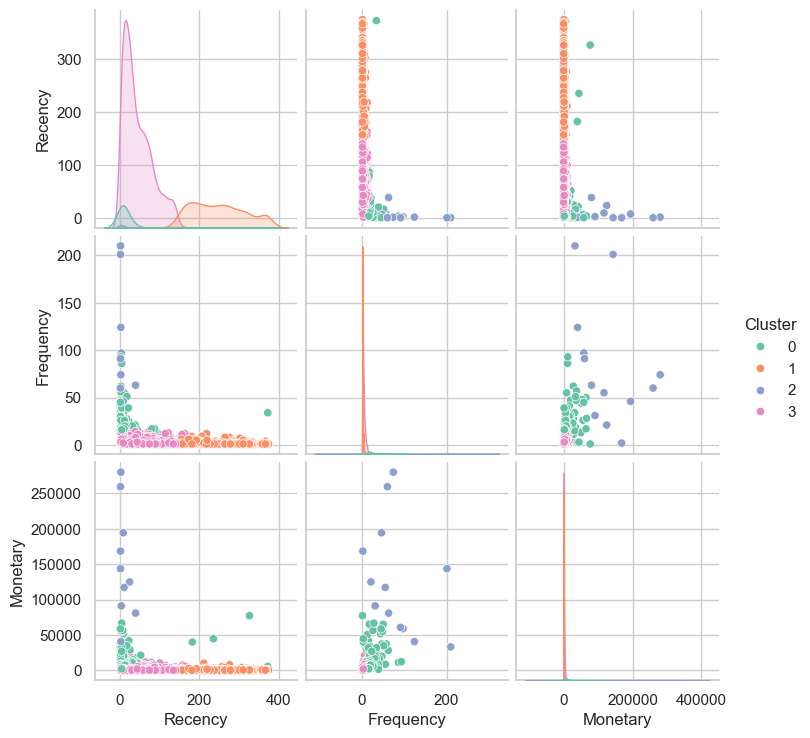

In [20]:
# Visualização com gráficos
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2', s=100)
plt.title('Clusters de Clientes')
plt.show()

sns.pairplot(rfm, vars=['Recency', 'Frequency', 'Monetary'], hue='Cluster', palette='Set2')
plt.show()


## Etapa 06 - Insights e Recomendações

**Cluster 0:** Clientes com alta frequência e alto gasto → *Clientes VIP*  
**Cluster 1:** Clientes recentes, mas com pouca frequência e gasto → *Novos Clientes*  
**Cluster 2:** Clientes com baixa frequência e recência alta → *Clientes Inativos*  
**Cluster 3:** Compram com frequência, mas com baixo ticket médio → *Clientes Regulares com Baixo Valor*

### Recomendações:
- **VIPs**: Campanhas de fidelização, acesso exclusivo a lançamentos.
- **Novos**: Ofertas de boas-vindas e onboarding com produtos populares.
- **Inativos**: Campanhas de reativação com descontos personalizados.
- **Regulares**: Incentivar compras maiores com promoções progressivas.

--- 
